# Rosenbrocks system Analysis

All needed information for controller design of Rosenbrocks system

In [1]:
# Import the needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as cn
import paperfunction as pf
#import modelicares as mres

## System evaluation

Compute the poles and zeros of the tranfer function.

First, get the approximation of the system which is decoupled via the simple static decoupler.

$g^*_{11} = \frac{1-s}{(s+1)(s+3)} $

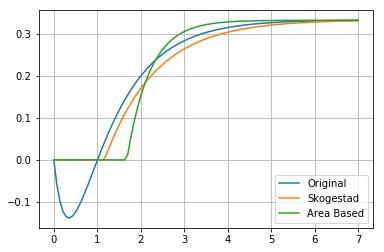

(0.33333333333333331, 1.1666666666666667, 1.1666666666666667)

In [9]:
# Get the real , delay free system
g = cn.tf([-1.,1.],[1.,1.])*cn.tf([1./3.],[1./3.,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den, L = 0.)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()
K,T,L

So, the model is given by:

$g^*_{11} = \frac{1}{3} \frac{1}{1.16666...s+1}e^{-1.166666s}$

Since for a simple dynamic decoupler the transfer functions stays the same, the approximation holds further.

The AMIGO parameter can be calculated to:

In [8]:
# First controller
c11,b11 = pf.AMIGO_TUNE(K,T,L)
# Second controller, simple static decoupler g_22
c22, b22 = pf.AMIGO_TUNE(K,1.,0.)

c11, c22

([0.75, 0.6428571428571429, 0.0],
 [8.4706611570247929, 13.939179257273754, 0.0])

So the resulting controller for a simple static decoupler is given by:

$c_{S,11} = 0.75 + \frac{0.642...}{s}$ 

$c_{S,22} = 2.1748... + \frac{2.5565...}{s}$

And for a simple dynamic decoupler:

$c_{D,11} = 0.75 + \frac{0.642...}{s}$ 

$c_{D,22} = 0.75 + \frac{0.642...}{s}$

Now, the generalized multivariable controller is calculated. Since the process is hard to automate, look into the draft of the paper.

## Simulation

Simulate the dymola systems via the interface.

In [5]:
# General Information

# Modelica Package name
Package = "Rosenbrock"

# Make an array of models to automate the evaluation
models = ['Ideal','Decentralized', 'Static_Decoupling', 'Dynamic_Decoupling', 'Centralized_PID']

# Model to simulate, here the folder and the modelica file containing the model needs to be specified.
Model_Path = "../Modelica/Rosenbrock.mo"

# Simulation Parameter, here the simulation parameter have to be specified.
sim_parameter = {
    "stopTime" : 1200,
    "Intervals": 1e2,
    "OutputInterval" : 0.1,
    "Stepsize" : 0.1,
    "finalNames" : ["y_1","y_2","u_1","u_2", "IAE_1.y", "IAE_2.y", "IE_1", "IE_2"],
}


### System Analysis

Analyze the system without gains.

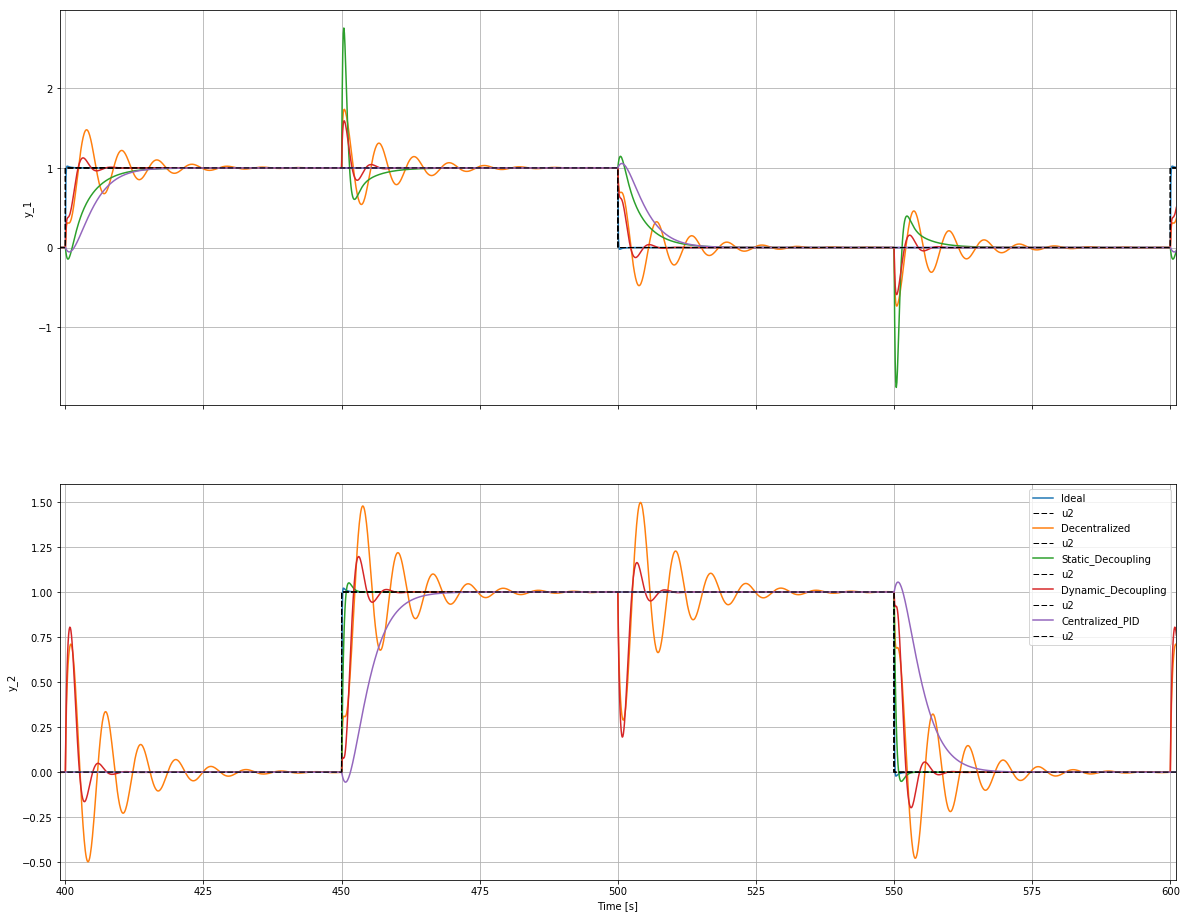

In [6]:
# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo", Show = False)

# Make a plot
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

# Loop over all models in the modelica file
for model_names in models:

    # Update the simulation parameter
    sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names})
    # Run the current simulation
    pf.Run_Simulation(model, sim_parameter)
    # Get the result data
    Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+".mat")
    # Apply the data to the plot
    ax[0].plot(Data["time"], Data["y1"], label = model_names)
    ax[0].plot(Data["time"], Data["u1"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)
    
    ax[1].plot(Data["time"], Data["y2"], label = model_names)
    ax[1].plot(Data["time"], Data["u2"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)

# Close the current simulation instance
model.close()

# Add the layout to the plot
ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([399,601])
plt.show()

### Gain Study for Decentralized system

Decentralized controlled system;

Steps to be taken:
- Get the system behaviour without additional gain
- Amplify every gain K_11 / K_22 individually until the closed loop collapses
- Amplify both gains until the closed loop collapses

In [11]:
# Gain Increment and maximum Gain
dK = .1
KMax = 70

# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo")

# Make a list for gain storage
maximum_gains = {}

# Loop over all models in the modelica file except "Ideal"
for model_names in models:
    
    # Inner loop, increase the gain of u_1
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K11"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[K,1.]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K11.mat")
        # Check the stability
        stability = pf.Stability(Data["y1"].values,Data["u1"].values) and pf.Stability(Data["y2"].values,Data["u2"].values)


    # Get the last stable gain
    maximum_gains.update({model_names+"_K11" : K-dK})
    
    # Inner loop, increase the gain of u_2
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K22"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[1.,K]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K22.mat")
        # Check the stability
        stability = pf.Stability(Data["y1"].values,Data["u1"].values) and pf.Stability(Data["y2"].values,Data["u2"].values)
    # Get the last stable gain
    maximum_gains.update({model_names+"_K22" : K-dK})
    
    # Inner loop, increase the gain of u_1 and u_2
    # Make the gains
    #K = 1.
    # Start with stable system
    #stability = True
    
    #while stability:
        # Increase the gain
    #    if (K < KMax):
    #        K = K + dK
    #    else:
    #        break
        
        # Update the simulation parameter
    #    sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_Gain"})
    #    sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[K,K]})
        # Simulate the model
    #    pf.Run_Simulation(model, sim_parameter)
        # Load the results
    #    Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_Gain.mat")
        # Check the stability
    #    stability = pf.Stability(Data["y1"].values,Data["u1"].values) and pf.Stability(Data["y2"].values,Data["u2"].values)
    #    if K11 > KMax or K22 > KMax :
    #        break
    # Get the last stable gain
    #maximum_gains.update({model_names+"_K" : K-dK})

# Close the model
model.close()    

0

In [12]:
maximum_gains

{'Centralized_PID_K11': 5.799999999999996,
 'Centralized_PID_K22': 5.799999999999996,
 'Decentralized_K11': 1.7000000000000006,
 'Decentralized_K22': 1.7000000000000006,
 'Dynamic_Decoupling_K11': 69.9000000000003,
 'Dynamic_Decoupling_K22': 69.9000000000003,
 'Ideal_K11': 69.9000000000003,
 'Ideal_K22': 69.9000000000003,
 'Static_Decoupling_K11': 1.3000000000000003,
 'Static_Decoupling_K22': 69.9000000000003}